# Capstone project: Classify robot failures
### Optional challenge: read the raw data files and format them correctly to save as CSV files

In [ ]:
import pandas as pd

# Initialize lists to store data
labels = []
values = []
all_labels = []

def is_numeric_line(line):
    try:
        [int(num) for num in line.split()]
        return True
    except ValueError:
        return False

# Open the file and read through the data line by line
with open('data/lp5.data', 'r') as file:
    current_label = None
    for line in file:
        line = line.strip()
        if line:
            if is_numeric_line(line):
                values.append([int(num) for num in line.split()])
                labels.append(current_label)
            else:
                current_label = line.strip()
                all_labels.append(current_label)

# Create DataFrame for the numeric values
columns = ['F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']
df = pd.DataFrame(values, columns=columns)

# Add 'timestep' column
df['timestep'] = [i % 15 + 1 for i in range(len(df))]

# Add 'id' column (constant value per 15 rows)
df['id'] = [i // 15 for i in range(len(df))]
df = df[['id', 'timestep', 'F_x', 'F_y', 'F_z', 'T_x', 'T_y', 'T_z']]
df.to_csv('data/lp5_X.csv', header=True, index=False)

# Create DataFrame for the labels
labels_df = pd.DataFrame(all_labels, columns=['label'])
labels_df.to_csv('data/lp5_y.csv', header=True, index=False)

# Print the DataFrames
print("DataFrame with numeric values:")
print(df)
print("\nDataFrame with labels:")
print(labels_df)

## 1. Initial setup

In [50]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support 

from sktime.classification.dictionary_based import WEASEL
from sktime.classification.ensemble import BaggingClassifier
from sktime.classification.feature_based import SummaryClassifier, Catch22Classifier

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from tsfresh import extract_features, select_features

import warnings
warnings.filterwarnings('ignore')

### Read data (lp1 data)

In [51]:
X = pd.read_csv('data/lp1_X.csv')
y = pd.read_csv('data/lp1_y.csv').squeeze()

X.head()

,id,timestep,F_x,F_y,F_z,T_x,T_y,T_z
0,0,1,-1,-1,63,-3,-1,0
1,0,2,0,0,62,-3,-1,0
2,0,3,-1,-1,61,-3,0,0
3,0,4,-1,-1,63,-2,-1,0
4,0,5,-1,-1,63,-3,-1,0


In [52]:
X = X.set_index(['id', 'timestep'])
X.head()

F_x  F_y  F_z  T_x  T_y  T_z
id timestep                              
0  1          -1   -1   63   -3   -1    0
   2           0    0   62   -3   -1    0
   3          -1   -1   61   -3    0    0
   4          -1   -1   63   -2   -1    0
   5          -1   -1   63   -3   -1    0

In [53]:
y.value_counts()

label
obstruction     34
normal          21
collision       17
fr_collision    16
Name: count, dtype: int64

### Train/test split

In [54]:
obstruction_indices = y.loc[y == 'obstruction'].index
normal_indices = y.loc[y == 'normal'].index
collision_indices = y.loc[y == 'collision'].index
fr_collision_indices = y.loc[y == 'fr_collision'].index

In [55]:
split_idx = math.floor(len(obstruction_indices)/2)
train_obst_idx = pd.Index(obstruction_indices.tolist()[:split_idx])
test_obst_idx = pd.Index(obstruction_indices.tolist()[split_idx:])

split_idx = math.floor(len(normal_indices)/2)
train_normal_idx = pd.Index(normal_indices.tolist()[:split_idx])
test_normal_idx = pd.Index(normal_indices.tolist()[split_idx:])

split_idx = math.floor(len(collision_indices)/2)
train_col_idx = pd.Index(collision_indices.tolist()[:split_idx])
test_col_idx = pd.Index(collision_indices.tolist()[split_idx:])

split_idx = math.floor(len(fr_collision_indices)/2)
train_frcol_idx = pd.Index(fr_collision_indices.tolist()[:split_idx])
test_frcol_idx = pd.Index(fr_collision_indices.tolist()[split_idx:])

train_index = pd.Index(pd.concat([pd.Series(idx) for idx in [train_obst_idx, train_normal_idx, train_col_idx, train_frcol_idx]]))
test_index = pd.Index(pd.concat([pd.Series(idx) for idx in [test_obst_idx, test_normal_idx, test_col_idx, test_frcol_idx]]))

print(train_index)
print(test_index)

Index([35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 57,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 18, 19, 20, 21, 22, 23, 24, 25, 52,
       54, 55, 56, 58, 62, 68, 69],
      dtype='int64')
Index([59, 60, 61, 63, 64, 65, 66, 70, 72, 73, 75, 77, 78, 80, 83, 85, 86, 10,
       11, 12, 13, 14, 15, 16, 17, 40, 42, 67, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 71, 74, 76, 79, 81, 82, 84, 87],
      dtype='int64')


In [56]:
X_train, y_train = X.loc[train_index], y.iloc[train_index]
X_test, y_test = X.loc[test_index], y.iloc[test_index]

## 2. Modeling

In [57]:
label_mapping = {
    'obstruction': 0,
    'normal': 1,
    'collision': 2,
    'fr_collision': 3
}

y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)

### Bagging

In [58]:
base_clf = WEASEL(alphabet_size=3,support_probabilities=True, random_state=42)

clf = BaggingClassifier(base_clf, n_estimators=6, n_features=1, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf_report = classification_report(y_test, y_pred)

precision_bagging, recall_bagging, fscore_bagging, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print(clf_report)

              precision    recall  f1-score   support

           0       0.46      0.71      0.56        17
           1       0.82      0.82      0.82        11
           2       1.00      0.11      0.20         9
           3       0.29      0.25      0.27         8

    accuracy                           0.53        45
   macro avg       0.64      0.47      0.46        45
weighted avg       0.63      0.53      0.50        45



### Summary classifier

In [59]:
knn_clf = KNeighborsClassifier(n_neighbors=1)
ada_clf = AdaBoostClassifier(n_estimators=10, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svc_clf = SVC()

classifiers = [knn_clf, ada_clf, rf_clf, svc_clf]

for classifier in classifiers:
    clf = SummaryClassifier(
        summary_functions=("mean", "min", "max", "median", "sum", "skew", "kurt", "var", "std", "mad", "sem", "nunique", "count"),
        estimator=classifier,
        n_jobs=-1,
        random_state=42
    )
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"Precision {precision} \nRecall: {recall} \nF1-Score: {fscore} \n===================")

Precision 0.7805982905982906 
Recall: 0.6222222222222222 
F1-Score: 0.6196712487035068 
Precision 0.6914529914529914 
Recall: 0.6222222222222222 
F1-Score: 0.5890793650793651 
Precision 0.8459259259259259 
Recall: 0.7333333333333333 
F1-Score: 0.7297517297517297 
Precision 0.45045045045045046 
Recall: 0.4222222222222222 
F1-Score: 0.3538148148148148 


Here, random forest achieves the best result, with a precision of 0.85, recall of 0.73 and F1-Score of 0.73.

### TSFresh

In [60]:
X = pd.read_csv('data/lp1_X.csv')
y = pd.read_csv('data/lp1_y.csv').squeeze()

In [61]:
X_feat = extract_features(X, column_id='id', column_sort='timestep')
X_feat = X_feat.dropna(axis=1)

X_train, y_train = X_feat.iloc[train_index], y.iloc[train_index]
X_test, y_test = X_feat.iloc[test_index], y.iloc[test_index]

# X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.5, stratify=y)

X_train_filtered = select_features(X_train, y_train, multiclass=True, n_significant=1)
X_test_filtered = X_test[X_train_filtered.columns]

classifiers = [knn_clf, ada_clf, rf_clf, svc_clf]

for classifier in classifiers:
       
    classifier.fit(X_train_filtered, y_train)
    
    y_pred = classifier.predict(X_test_filtered)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    print(f"Precision {precision} \nRecall: {recall} \nF1-Score: {fscore} \n===================")


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.65it/s]


Precision 0.8751262626262627 
Recall: 0.8222222222222222 
F1-Score: 0.8131801181414461 
Precision 0.8438095238095239 
Recall: 0.7333333333333333 
F1-Score: 0.7091986113725244 
Precision 0.8161236424394319 
Recall: 0.6666666666666666 
F1-Score: 0.642178077066966 
Precision 0.14271604938271606 
Recall: 0.37777777777777777 
F1-Score: 0.207168458781362 


## 3. Evaluation

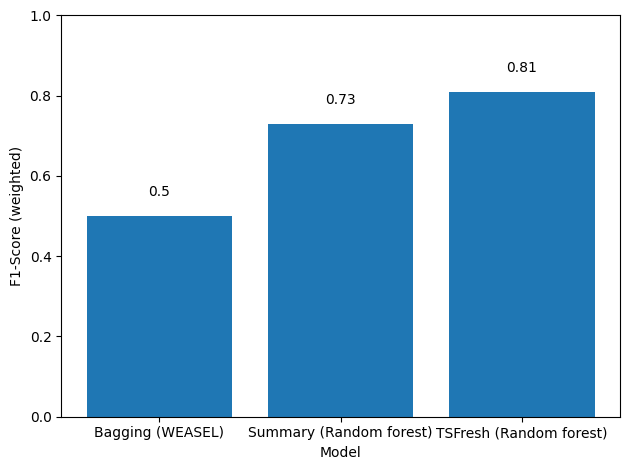

In [62]:
x = ['Bagging (WEASEL)', 'Summary (Random forest)', 'TSFresh (Random forest)']
y = [0.50, 0.73, 0.81]

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xlabel('Model')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1)

for i, v in enumerate(y):
    ax.text(x=i, y=v+0.05, s=str(v), ha='center')

plt.tight_layout()